Name : Ramya Gopinath

USC ID : 4595082262

Github username : ramyagopinath08

In [4]:
#import statements 
import pandas as pd
import numpy as np
import math

#import statements plotting the plots
import matplotlib.pyplot as plt
import seaborn as sns

#import statements for RidgeCV, LassoCV, PCR
from sklearn import tree,preprocessing
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV,LassoCV
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

#import statements for XGboost
from xgboost import XGBRegressor,cv
import xgboost as xgb

In [5]:
import warnings
warnings.filterwarnings("ignore")

## 1. Decision Trees as Interpretable Models

**(a) Download the Accute Inflamations data from https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations.**

In [6]:
#importing the data frame 
column_name = ['Temperature of patient', 'Occurrence of nausea','Lumbar pain','Urine pushing','Micturition pains','Burning of urethra/itch/swelling',
               'Inflammation of urinary bladder', 'Nephritis of renal pelvis origin']
data_frame = pd.read_csv('../Data/diagnosis.data', sep="\t", encoding='utf-16', names= column_name , decimal=",")
data_frame.head()

,Temperature of patient,Occurrence of nausea,Lumbar pain,Urine pushing,Micturition pains,Burning of urethra/itch/swelling,Inflammation of urinary bladder,Nephritis of renal pelvis origin
0,35.5,no,yes,no,no,no,no,no
1,35.9,no,no,yes,yes,yes,yes,no
2,35.9,no,yes,no,no,no,no,no
3,36.0,no,no,yes,yes,yes,yes,no
4,36.0,no,yes,no,no,no,no,no


**(b) Build a decision tree on the whole data set and plot it.**

In [7]:
#Dividing the data frame into x and y and assigning values for it. where the value is yes:1 and no:0
x = data_frame.iloc[:,:6]
y = data_frame.iloc[:,-2:]
for col in x.columns[1:]:
    x[col] = x[col].map({'yes': 1, 'no': 0})
for col in y.columns:
    y[col] = y[col].map({'yes': 1, 'no': 0})

In [8]:
#Building the decision tree 
decision_Tree = tree.DecisionTreeClassifier(random_state=0)
decision_Tree.fit(x,y)

DecisionTreeClassifier(random_state=0)

In [9]:
#Plotting the decision tree using graphviz as in the provided documnetation
dotfile = open("decision_Tree.dot", 'w')
tree.export_graphviz(decision_Tree, out_file=dotfile, feature_names=column_name[:-2])
dotfile.close()

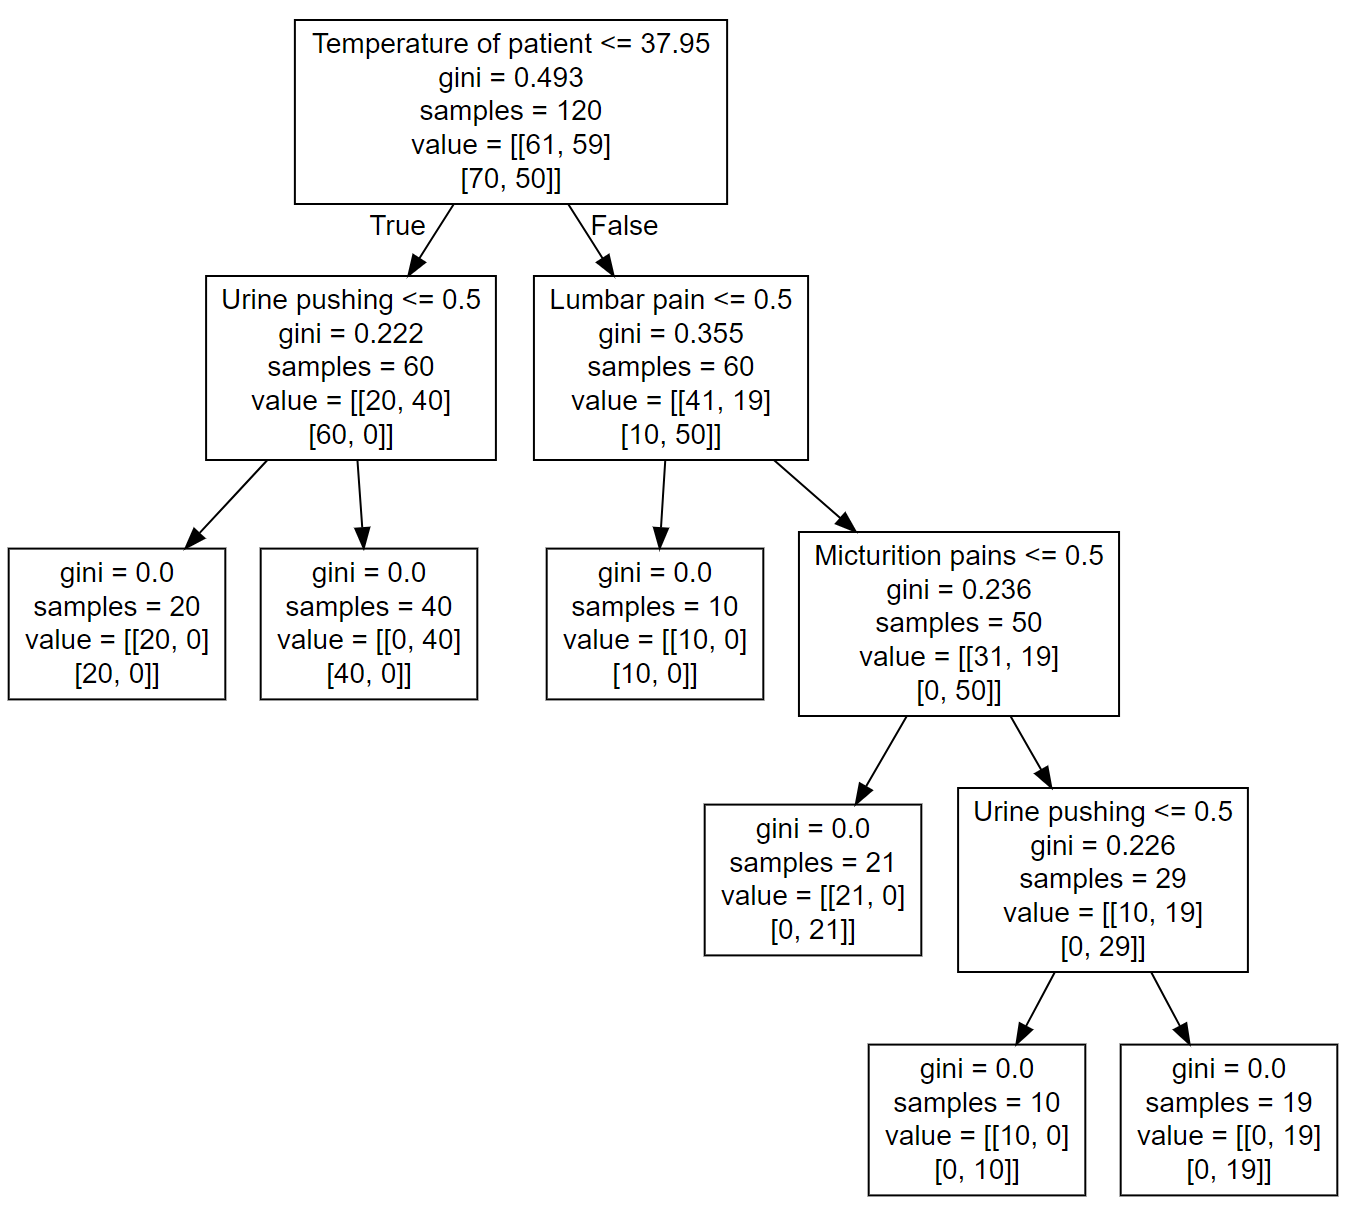

**(c) Convert the decision rules into a set of IF-THEN rules**

In [10]:
#pseudo code for implementing IF-THEN rule as in the provided document 
def tree_to_pseudo(tree, feature_names):
    '''
     Outputs a decision tree model as if/then pseudocode
     Parameters:
     -----------
     tree: decision tree model
     The decision tree to represent as pseudocode
     feature_names: list
     The feature names of the dataset used for building the decision tree
     '''
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):
        indent = " " * depth
        if (threshold[node] != -2):
            print (indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
            if left[node] != -1:
                recurse (left, right, threshold, features, left[node], depth+1)
                print (indent,"} else {")
                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)
                print (indent,"}")
        else:
            print (indent,"return \n" + str(value[node]))
    recurse(left, right, threshold, features, 0)

In [11]:
#Building the IF-THEN rule for the fitted decision tree
tree_to_pseudo(decision_Tree,column_name[:-2])

 if ( Temperature of patient <= 37.95000076293945 ) {
  if ( Urine pushing <= 0.5 ) {
   return 
[[20.  0.]
 [20.  0.]]
  } else {
   return 
[[ 0. 40.]
 [40.  0.]]
  }
 } else {
  if ( Lumbar pain <= 0.5 ) {
   return 
[[10.  0.]
 [10.  0.]]
  } else {
   if ( Micturition pains <= 0.5 ) {
    return 
[[21.  0.]
 [ 0. 21.]]
   } else {
    if ( Urine pushing <= 0.5 ) {
     return 
[[10.  0.]
 [ 0. 10.]]
    } else {
     return 
[[ 0. 19.]
 [ 0. 19.]]
    }
   }
  }
 }


**Minimal decision tree**

**(d) Use cost-complexity pruning to find a minimal decision tree and a set of decision
rules with high interpretability.**

The best alpha value is : 0.0


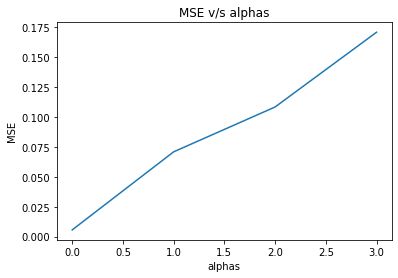

In [12]:
#Fitting the decision tree and purning the tree using cost complexity pruning 
mse_tree = []
tree = DecisionTreeClassifier()
path = tree.cost_complexity_pruning_path(x,y)
alphas = path['ccp_alphas'][:-1]

#using the list of the alphas we find the best alpha value which has the lowest MSE tree
for i in alphas:
    tree_Decision = DecisionTreeClassifier(ccp_alpha=i)
    score = -1 * model_selection.cross_val_score(tree_Decision,x,y,cv = RepeatedKFold(n_splits=5,n_repeats=3),
                                                scoring="neg_mean_squared_error").mean()
    
    mse_tree.append(score)

#The graph below shows that as the alpha value increases the MSE increases for this data set
plt.plot(mse_tree)
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.title('MSE v/s alphas')
best_alpha = alphas[mse_tree.index(min(mse_tree))]
print(f"The best alpha value is : {best_alpha}")

In [13]:
#Using the best alpha we fit the decision tree to obtain the IF-THEN rule
best_tree_classifer = DecisionTreeClassifier(ccp_alpha=best_alpha).fit(x,y)

In [14]:
tree_to_pseudo(best_tree_classifer,column_name[:-2])

 if ( Temperature of patient <= 37.95000076293945 ) {
  if ( Urine pushing <= 0.5 ) {
   return 
[[20.  0.]
 [20.  0.]]
  } else {
   return 
[[ 0. 40.]
 [40.  0.]]
  }
 } else {
  if ( Lumbar pain <= 0.5 ) {
   return 
[[10.  0.]
 [10.  0.]]
  } else {
   if ( Occurrence of nausea <= 0.5 ) {
    return 
[[21.  0.]
 [ 0. 21.]]
   } else {
    if ( Urine pushing <= 0.5 ) {
     return 
[[10.  0.]
 [ 0. 10.]]
    } else {
     return 
[[ 0. 19.]
 [ 0. 19.]]
    }
   }
  }
 }


# 2. The LASSO and Boosting for Regression

**(a) Download the Communities and Crime data3
from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as
the training set and the rest as the test set.**

In [15]:
#read the column names from a text file and then read the csv file. Also removing the not predictive columns
column_names_CC = open("../Data/column_names_CC.txt").read().splitlines()
Communities_Crime_df = pd.read_csv('../Data/communities.data', names=column_names_CC, na_values="?" )
Communities_Crime_df = Communities_Crime_df.iloc[:,5:]
Communities_Crime_df

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


In [16]:
#Train test data split
train_DF = Communities_Crime_df.iloc[:1494,:]
test_DF = Communities_Crime_df.iloc[1494:,:]

**(b) The data set has missing values. Use a data imputation technique to deal with
the missing values in the data set. The data description mentions some features
are nonpredictive. Ignore those features.**

In [17]:
#Imputation for Nan values for "train data set" using simple imputer mean
impute_mean_train = SimpleImputer(strategy='mean')
impute_mean_train.fit(train_DF)
train_imputed = impute_mean_train.transform(train_DF)
train_imputed = pd.DataFrame(train_imputed, columns=column_names_CC[5:])
train_imputed.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.164664,0.080798,0.712815,0.453782,0.00,0.190798,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.164664,0.080798,0.712815,0.453782,0.00,0.190798,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.164664,0.080798,0.712815,0.453782,0.00,0.190798,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.164664,0.080798,0.712815,0.453782,0.00,0.190798,0.03


In [18]:
#Train data set slipt in to x and y train
x_train = train_imputed.iloc[:,:-1]
y_train = train_imputed.iloc[:,-1:]

In [19]:
#Imputation for Nan values for "test data set" using simple imputer mean
impute_mean_test = SimpleImputer(strategy='mean')
impute_mean_test.fit(test_DF)
test_imputed = impute_mean_test.transform(test_DF)
test_imputed = pd.DataFrame(test_imputed, columns=column_names_CC[5:])
test_imputed.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.05,0.43,0.08,0.65,0.12,1.00,0.37,0.52,0.33,0.44,...,0.00,1.00,1.00,0.000000,0.010000,0.77000,0.000000,0.51,0.180000,0.23
1,0.00,0.20,0.03,0.91,0.23,0.05,0.15,0.19,0.09,0.42,...,0.01,0.23,0.73,0.158519,0.064691,0.65679,0.401235,0.00,0.207654,0.12
2,0.00,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,0.10,...,0.01,0.18,0.02,0.158519,0.064691,0.65679,0.401235,0.00,0.207654,0.11
3,0.00,0.52,0.04,0.59,0.05,0.62,0.84,0.78,0.75,0.43,...,0.01,0.18,0.00,0.158519,0.064691,0.65679,0.401235,0.00,0.207654,0.12
4,0.04,0.51,0.07,0.92,0.09,0.03,0.38,0.47,0.27,0.35,...,0.06,0.13,0.16,0.158519,0.064691,0.65679,0.401235,0.00,0.207654,0.06


In [20]:
#Test data set split into x and y test
x_test = test_imputed.iloc[:,:-1]
y_test = test_imputed.iloc[:,-1:]

**(c) Plot a correlation matrix for the features in the data set.**

In [21]:
#printing the correlation matrix using the corr function
frames = [train_DF,test_DF]
combine_dataframe = pd.concat(frames)
corr = combine_dataframe.corr()
corr.style.background_gradient(cmap='coolwarm')

**(d) Calculate the Coefficient of Variation CV for each feature, where CV =s/m, in which s is sample standard deviation and m is sample mean.**

In [22]:
#Calculating the CV value for each of the features
cv = lambda x: np.std(x) / np.mean(x)
calculated_CV = combine_dataframe.apply(cv)
calculated_CV

population             2.202950
householdsize          0.353210
racepctblack           1.410567
racePctWhite           0.323700
racePctAsian           1.358821
                         ...   
LemasPctPolicOnPatr    0.305771
LemasGangUnitDeploy    0.919927
LemasPctOfficDrugUn    2.554625
PolicBudgPerPop        0.843043
ViolentCrimesPerPop    0.978769
Length: 123, dtype: float64

**(e) Pick
√
128 features with highest CV , and make scatter plots and box plots for
them. Can you draw conclusions about significance of those features, just by the
scatter plots?**

In [23]:
#Picking the √128 features from the above which has the highest CV value
feature_pick = math.floor(math.sqrt(128))
CV_highest_features = calculated_CV.sort_values(ascending=False)[:feature_pick]
CV_highest_features = pd.DataFrame(CV_highest_features, columns= ["CV values"])
CV_highest_features

,CV values
NumStreet,4.406597
NumInShelters,3.484607
NumIlleg,2.993446
NumImmig,2.899770
LemasPctOfficDrugUn,2.554625
NumUnderPov,2.304392
population,2.202950
numbUrban,2.001242
LemasSwornFT,1.981486
PctPolicAsian,1.976266


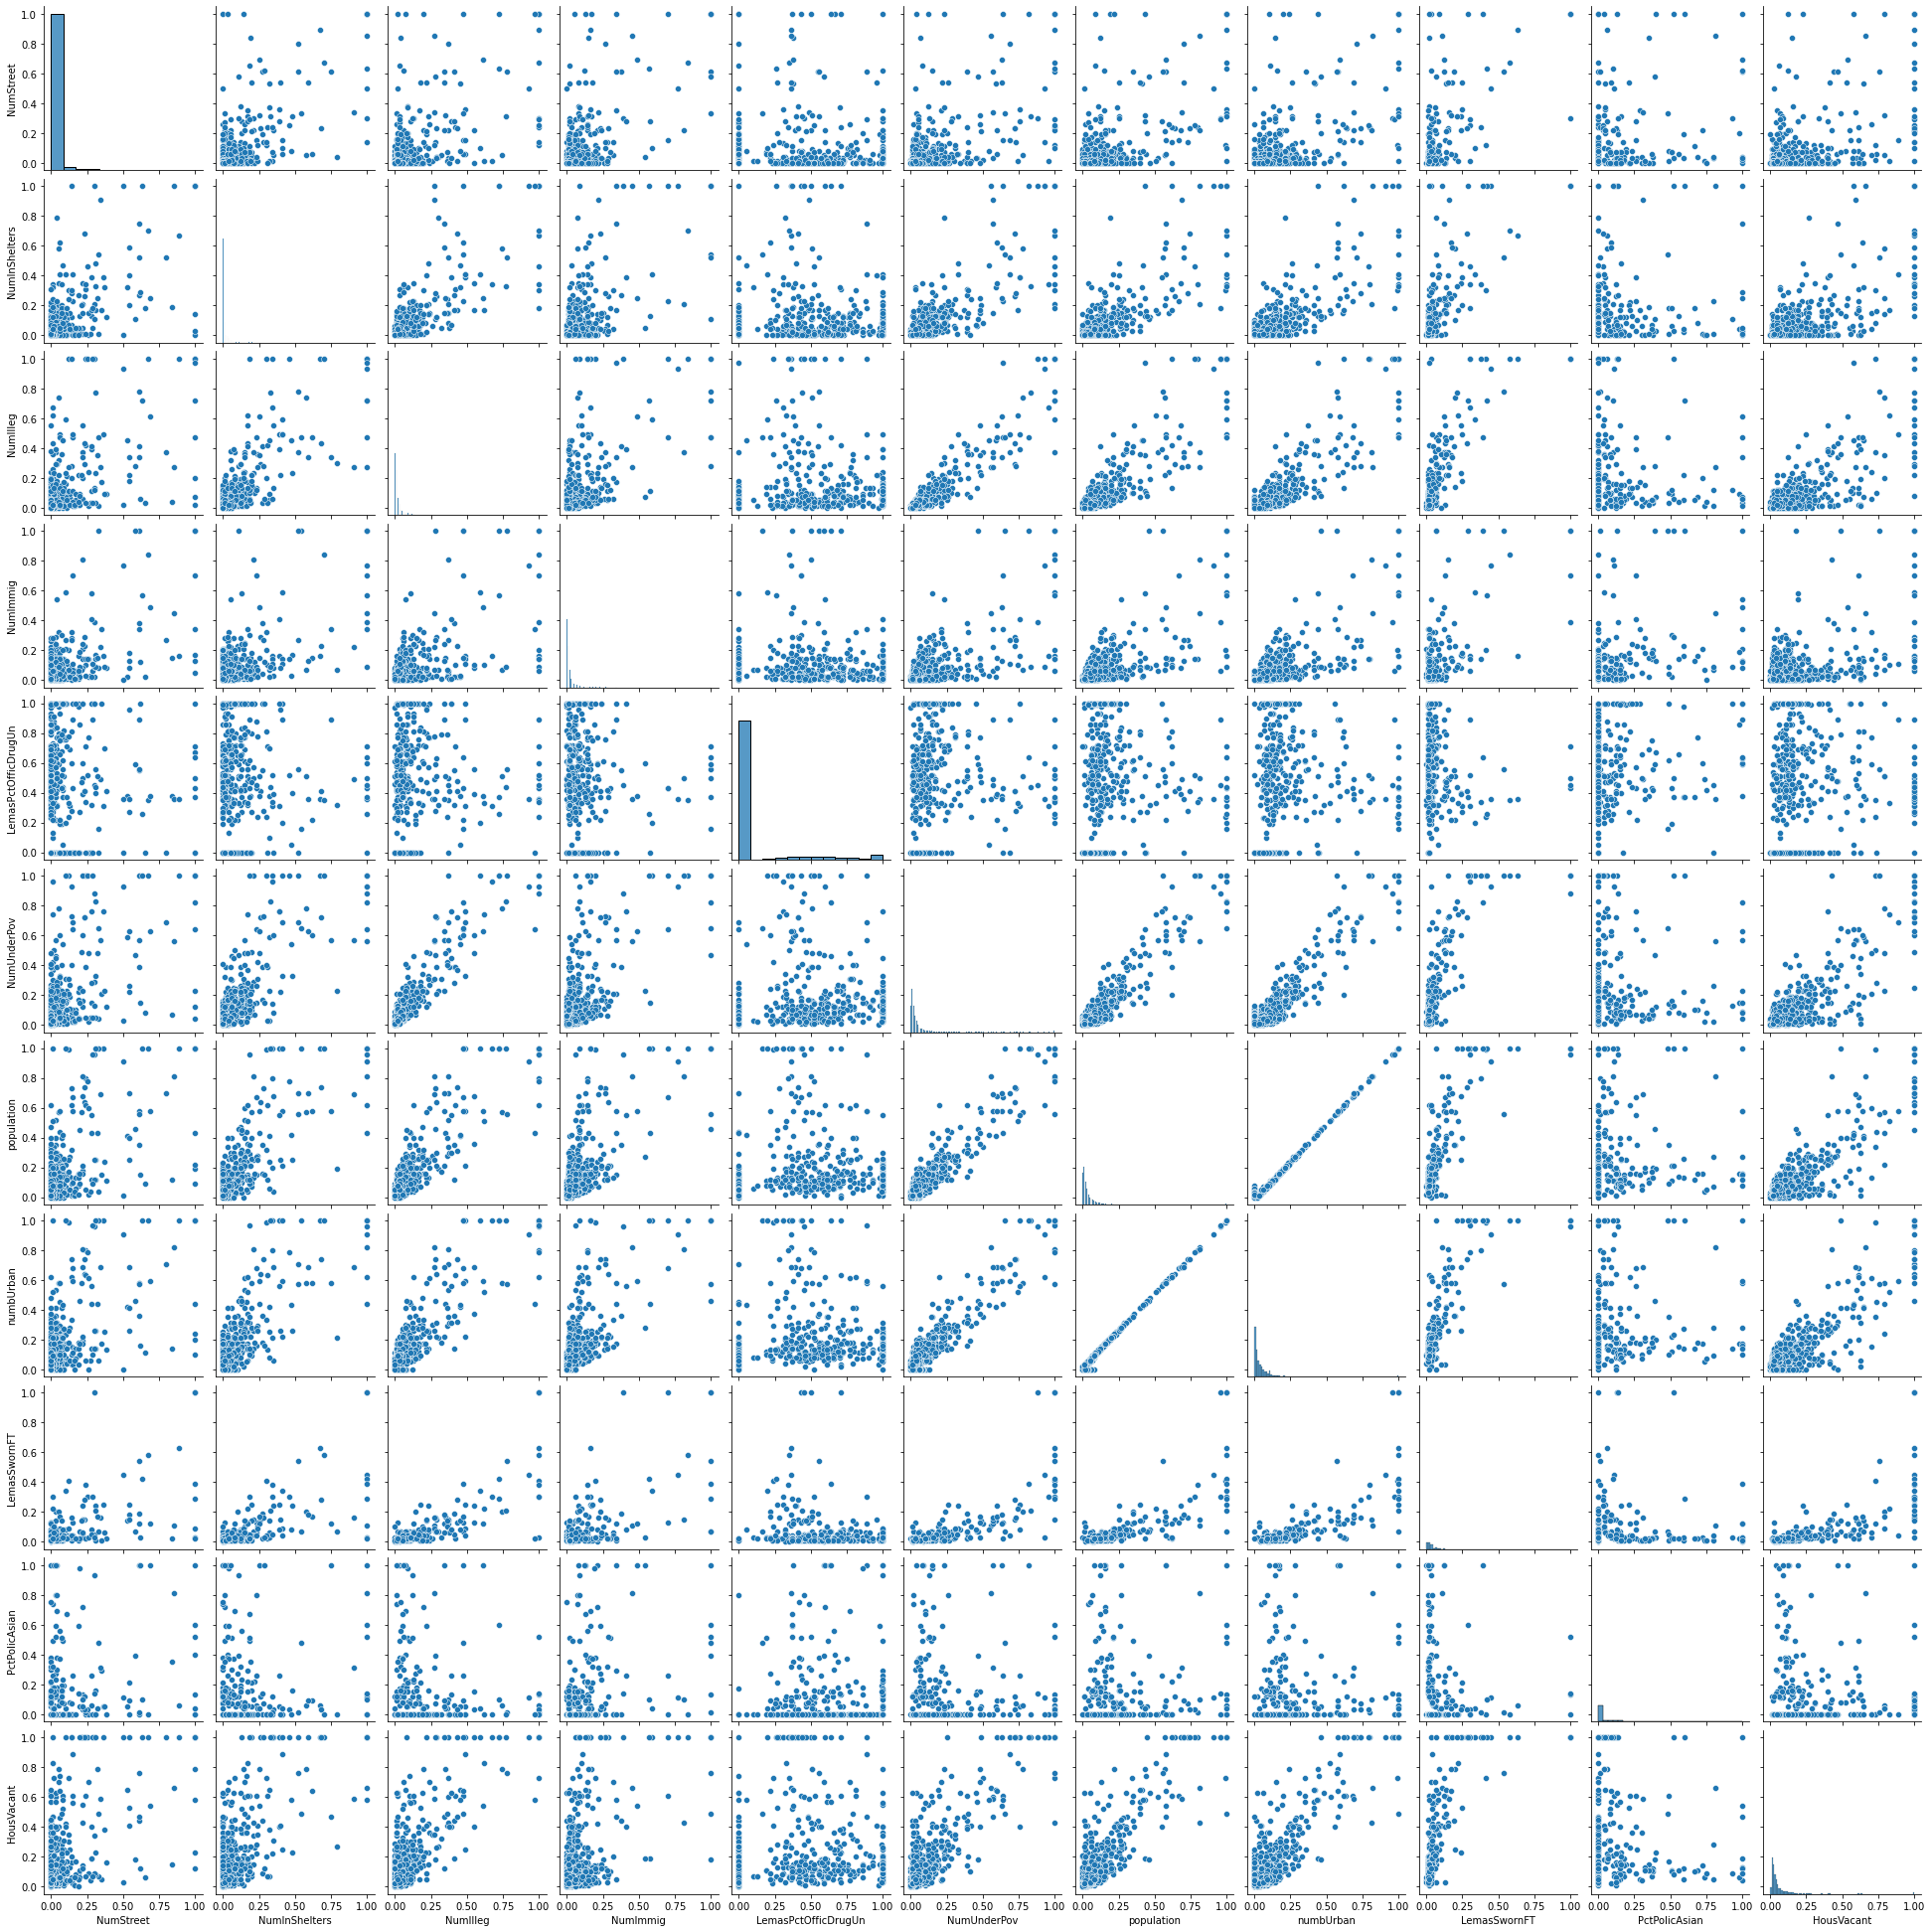

In [24]:
#Scatter plot 11 X 11 
sns.pairplot(combine_dataframe[CV_highest_features.index])

<AxesSubplot:>

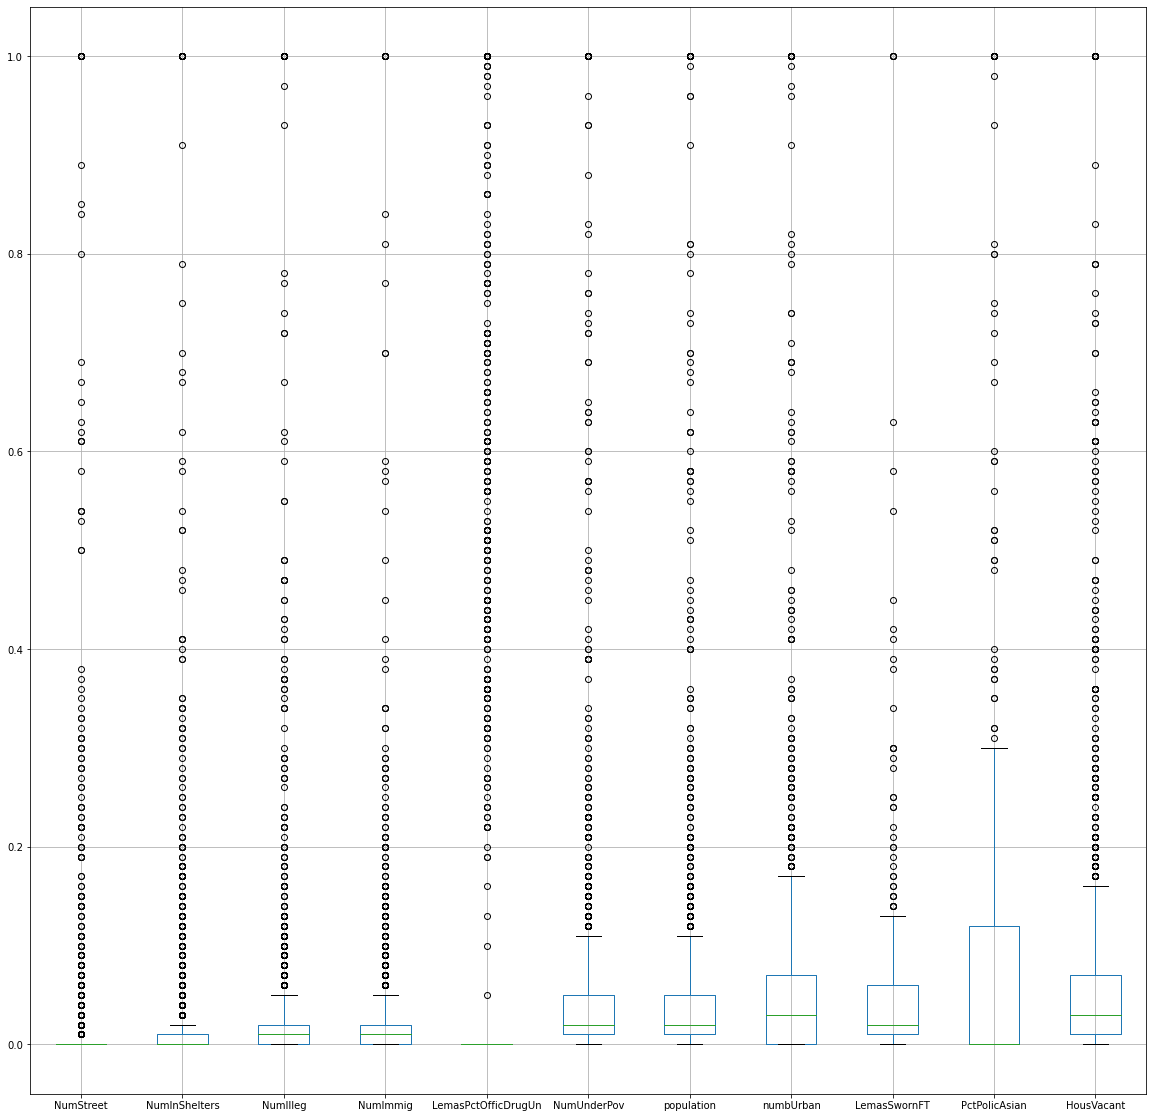

In [25]:
#Box plot for the 11 features 
plt.figure(figsize=(20,20))
combine_dataframe[CV_highest_features.index].boxplot()

**From the scatter plot we can see that Population and numbUrban has a strong positive correlation. From the box plot there is noting much we can conclude.Also, we can see that there are many outliers. But we cannot decide on the significance of any of the features without finding the p-values or without more investigation.**

**(f) Fit a linear model using least squares to the training set and report the test error.**

In [26]:
#Fitting a linear regression and displaying the test error
linear_reg = LinearRegression().fit(x_train,y_train)
y_predict_test = linear_reg.predict(x_test)

mse_test = mean_squared_error(y_test, y_predict_test)
test_score = linear_reg.score(x_test,y_test)

print(f"The mean square test error is :{mse_test}" )
print(f"The test error score is :{test_score}" )

The mean square test error is :3.7787643507815506e+18
The test error score is :-7.961966335957674e+19


**(g) Fit a ridge regression model on the training set, with λ chosen by cross-validation.
Report the test error obtained**

In [27]:
#Fitting a ridge model using ridgeCV and displaying the best alpha value and the test error
ridge_reg_CV = RidgeCV(cv=5)
ridge_reg_CV.fit(x_train,y_train)

y_predRidge_test = ridge_reg_CV.predict(x_test)
mse_test_Ridge = mean_squared_error(y_test, y_predRidge_test)
Ridge_score = ridge_reg_CV.score(x_test, y_test)

print(f"The mean square test error is :{mse_test_Ridge}" )
print(f"The test error score is :{Ridge_score}" )
print(f"The best alpha value is : {ridge_reg_CV.alpha_}")

The mean square test error is :0.017809926018737435
The test error score is :0.6247396814311652
The best alpha value is : 1.0


**(h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report
the test error obtained, along with a list of the variables selected by the model.
Repeat with standardized
features. Report the test error for both cases and
compare them.**

In [28]:
#Fitting a Lasso model using losso CV. Displaying the best alpha value and the test error 
#This is for original data which is already normalized
#Fitting the lasso cv
lasso_reg_CV = LassoCV(cv=5, max_iter=1200)
lasso_reg_CV.fit(x_train,y_train.values.ravel())
lasso_reg_CV.score(x_test,y_test)

y_predLasso_test = lasso_reg_CV.predict(x_test)
mse_test_Lasso = mean_squared_error(y_test, y_predLasso_test)
Lasso_score = lasso_reg_CV.score(x_test, y_test)

print(f"The mean square test error is :{mse_test_Lasso}" )
print(f"The test error score is :{Lasso_score}" )
print(f"The best alpha value is : {lasso_reg_CV.alpha_}")

The mean square test error is :0.017827412903533693
The test error score is :0.6243712276850621
The best alpha value is : 0.00011622705969447207


In [29]:
df_lasso = pd.DataFrame(columns=["Mean Square Error"])
df_lasso.loc["Normalized data","Mean Square Error"] = mse_test_Lasso
# df_lasso

**Standardizing the data frame**

In [30]:
#Standardizing the data and the using lasso cv to find the best alpha and the test error

#standardizing data using standard scaler
scalar = StandardScaler()
scalar.fit(x_train,y_train)
x_train_std = scalar.transform(x_train,copy=True)
x_test_std = scalar.transform(x_test,copy=True)

#Fitting the lasso cv
lasso_reg_CV_std = LassoCV(cv=5, max_iter=1200)
lasso_reg_CV_std.fit(x_train_std,y_train.values.ravel())
lasso_reg_CV_std.score(x_test_std,y_test)

y_predLasso_test_std = lasso_reg_CV_std.predict(x_test_std)
mse_test_Lasso_std = mean_squared_error(y_test, y_predLasso_test_std)
Lasso_score_std = lasso_reg_CV_std.score(x_test_std, y_test)

print(f"The mean square test error is :{mse_test_Lasso_std}" )
print(f"The test error score is :{Lasso_score_std}" )
print(f"The best alpha value is : {lasso_reg_CV_std.alpha_}")

The mean square test error is :0.01790256164912957
The test error score is :0.6227878217695806
The best alpha value is : 0.000763649345449897


In [31]:
#Below table shows the Mean Square error comparision for the nomalized and standardized data 
df_lasso.loc["Standardized data","Mean Square Error"] = mse_test_Lasso_std
print(f"The MSE for LASSO when data is normalized and standardized")
df_lasso.T

The MSE for LASSO when data is normalized and standardized


,Normalized data,Standardized data
Mean Square Error,0.017827,0.017903


**From the above data we can see that standardizing the data hasnt made much of a difference in reducing the Mean Square error.**

**(i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.**


The number of principal componants M : 96


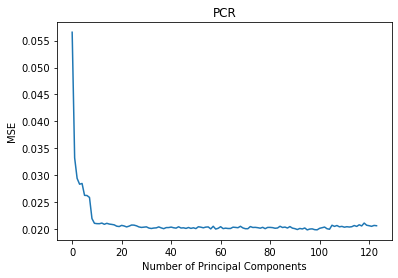

In [32]:
#Refered from the below link to implement PCR to find the best M
#https://www.statology.org/principal-components-regression-in-python/

#fit the pca model
pca = PCA()
x_reduced_pca = pca.fit_transform(scale(x_train))

#using the number of splits as 5
cv_pca = RepeatedKFold(n_splits=5,n_repeats=3)

#Preforming linear regression
linear_reg_pca = LinearRegression()
mse_values = []

# Calculate MSE with only the intercept
score = -1*model_selection.cross_val_score(linear_reg_pca,np.ones((len(x_reduced_pca),1)), y_train, cv=cv_pca,
           scoring='neg_mean_squared_error').mean()    
mse_values.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in range(1, train_DF.shape[1]+1):
    score = -1*model_selection.cross_val_score(linear_reg_pca,
               x_reduced_pca[:,:i], y_train, cv=cv_pca, scoring='neg_mean_squared_error').mean()
    mse_values.append(score)

principal_componants_M = mse_values.index(min(mse_values)) + 1
plt.plot(mse_values)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('PCR')

print(f"The number of principal componants M : {principal_componants_M}")

In [33]:
# Find Test Errors using found principal components
pcr_test = PCA(n_components=principal_componants_M)
x_reduced_train = pcr_test.fit_transform(scale(x_train))

x_reduced_test = pcr_test.transform(scale(x_test))

LinearReg_PCR = LinearRegression()
LinearReg_PCR.fit(x_reduced_train,y_train)

test_error_pcr = LinearReg_PCR.score(x_reduced_test,y_test)
y_pred_PCR = LinearReg_PCR.predict(x_reduced_test)
mse_pcr = mean_squared_error(y_test,y_pred_PCR)

print(f"Test Error for PCR Model is: {test_error_pcr}")
print(f"The Mean Squared Error for PCR Model is: {mse_pcr}")

Test Error for PCR Model is: 0.6021793783204508
The Mean Squared Error for PCR Model is: 0.018880642290829527


**(j) In this section, we would like to fit a boosting tree to the data. As in classification
trees, one can use any type of regression at each node to build a multivariate
regression tree. Because the number of variables is large in this problem, one
can use L1-penalized regression at each node. Such a tree is called L1 penalized
gradient boosting tree. You can use XGBoost
to fit the model tree. Determine
α (the regularization term) using cross-validation.**

The alpha value for lowest MSE of XGBoost: 2


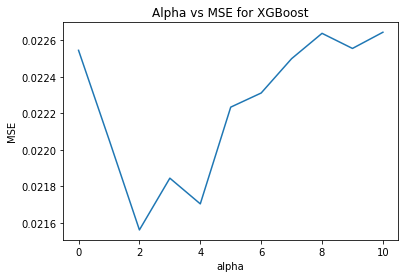

In [34]:
# Find best alpha for XGBoost with cross validation with 5 splits
cv_xgboost = RepeatedKFold(n_splits=5,n_repeats=3)
mse_list = []

#Find the best alpha value in the range of 0 to 10 using XGBRegressor
for alpha in range(0,11):
    xgboost_regressor = XGBRegressor(objective ='reg:squarederror', alpha = alpha, n_estimators = 10)
    score = -1 * model_selection.cross_val_score(xgboost_regressor, X = x_train,y = y_train,cv=cv_xgboost, scoring='neg_mean_squared_error').mean()
    mse_list.append(score)

best_alpha_value = mse_list.index(min(mse_list)) 

#Graph below shows the alpha values and the MSE
plt.plot(mse_list)
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Alpha vs MSE for XGBoost')

print(f"The alpha value for lowest MSE of XGBoost: {best_alpha_value}")

In [35]:
# Find Test MSE for test data suing the optimal alpha value
xgboost_bestalpha = XGBRegressor(objective ='reg:squarederror', alpha = best_alpha_value , n_estimators = 10).fit(x_train,y_train)

y_pred = xgboost_bestalpha.predict(x_test)
mse_test_xgboost = mean_squared_error(y_test,y_pred)

print(f"The MSE for test set on XGBoost: {mse_test_xgboost}")

The MSE for test set on XGBoost: 0.01759515603114432
